In [1]:
import os

import doctest
import numpy as np
import pandas as pd
  
from sklearn import metrics
from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

from fastai.structured import *
from fastai.column_data import *
PATH = 'data/'

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#torch.backends.cudnn.deterministic = True
#torch.manual_seed(999)

# Get Data

In [3]:
train = pd.read_csv('data/extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
test = pd.read_csv('data/extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)
train.shape, test.shape

((903653, 30), (804684, 30))

# Folding

# Feature engineering

In [4]:
train['totals.transactionRevenue'].fillna(0, inplace = True)
for df in [train, test]:
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df['date'].dt.dayofweek
    df['sess_date_hours'] = df['date'].dt.hour
    df['sess_date_dom'] = df['date'].dt.day
    df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df['next_session_1'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)
    ).astype(np.int64) // 1e9 // 60 // 60
    df['next_session_2'] = (
        df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)
    ).astype(np.int64) // 1e9 // 60 // 60
    
    df['time'] = df.visitStartTime.apply(lambda x: datetime.datetime.utcfromtimestamp(float(x)))

# Prepare data for deep-learning regression model

In [76]:
excluded_features = [
    'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'date', 'time']

cat_cols = [
    _f for _f in train.columns
    if (_f not in excluded_features) & (train[_f].dtype == 'object' or train[_f].dtype == 'int64' or _f == 'visitNumber')
]

num_cols = [c for c in train.columns if c not in cat_cols and c not in excluded_features]

In [77]:
num_cols

['device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.isTrueDirect']

In [78]:
dep = 'totals.transactionRevenue'
test[dep] = 0

In [79]:
# Model
print("prepare model ...")
X = train[cat_cols + num_cols + [dep, 'time']].copy()
X_test = test[cat_cols + num_cols + [dep, 'time']].copy()

prepare model ...


In [80]:
for v in cat_cols:
    print(v)
    X[v] = X[v].astype('category').cat.as_ordered()

channelGrouping
fullVisitorId
visitNumber
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
sess_date_dow
sess_date_hours
sess_date_dom
next_session_1
next_session_2


In [81]:
len(X.columns), len(X_test.columns), set(X_test.columns).difference(set(X.columns))

(32, 32, set())

In [82]:
apply_cats(X_test, X)
#if this does not work it is probably because of a duplicated column name ( throws dataframe has no attribute dtype error)

In [83]:
for v in num_cols:
    X[v] = X[v].astype('float32')
    X_test[v] = X_test[v].astype('float32')
    

X[dep] = X[dep].astype('float32')
X[dep] = X[dep].fillna(0)
X_test[dep] = X_test[dep].astype('float32')

## Create Dataframes for deep-learning

In [84]:
cat_sz = [(c, len(X[c].cat.categories)+1) for c in cat_cols]
cat_sz

[('channelGrouping', 9),
 ('fullVisitorId', 714168),
 ('visitNumber', 385),
 ('device.browser', 55),
 ('device.deviceCategory', 4),
 ('device.operatingSystem', 21),
 ('geoNetwork.city', 650),
 ('geoNetwork.continent', 7),
 ('geoNetwork.country', 223),
 ('geoNetwork.metro', 95),
 ('geoNetwork.networkDomain', 28065),
 ('geoNetwork.region', 377),
 ('geoNetwork.subContinent', 24),
 ('trafficSource.adContent', 45),
 ('trafficSource.campaign', 11),
 ('trafficSource.keyword', 3659),
 ('trafficSource.medium', 8),
 ('trafficSource.referralPath', 1476),
 ('trafficSource.source', 381),
 ('sess_date_dow', 8),
 ('sess_date_hours', 25),
 ('sess_date_dom', 32),
 ('next_session_1', 4023),
 ('next_session_2', 4023)]

In [85]:
emb_szs = [(c, max(10, min(50, (c+1)//2))) for _,c in cat_sz]
emb_szs

[(9, 10),
 (714168, 50),
 (385, 50),
 (55, 28),
 (4, 10),
 (21, 11),
 (650, 50),
 (7, 10),
 (223, 50),
 (95, 48),
 (28065, 50),
 (377, 50),
 (24, 12),
 (45, 23),
 (11, 10),
 (3659, 50),
 (8, 10),
 (1476, 50),
 (381, 50),
 (8, 10),
 (25, 13),
 (32, 16),
 (4023, 50),
 (4023, 50)]

In [86]:
import warnings; warnings.simplefilter('ignore')

In [87]:
def exp_rmse(y_pred, targ):
    return math.sqrt(mean_squared_error(targ, y_pred))

## Learning Visitor Level

In [88]:
X.sort_values(['time'], inplace = True)
X_test.sort_values(['time'], inplace = True)

In [89]:
X_indexed = X.set_index(['time'])
X_test_indexed = X_test.set_index(['time'])

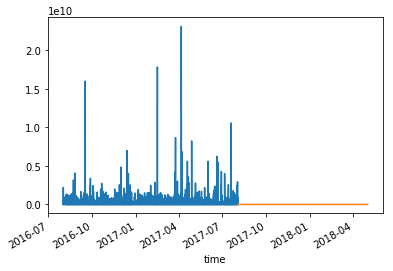

In [90]:
X_indexed['totals.transactionRevenue'].plot()
X_test_indexed['totals.transactionRevenue'].plot()

In [91]:
X_indexed.index.get_level_values(0).min(), X_indexed.index.get_level_values(0).max(), 
X_indexed.index.get_level_values(0).max() - X_indexed.index.get_level_values(0).min()

Timedelta('365 days 23:59:41')

In [92]:
X_test_indexed.index.get_level_values(0).min(), X_test_indexed.index.get_level_values(0).max(), 
X_test_indexed.index.get_level_values(0).max() - X_test_indexed.index.get_level_values(0).min()

Timedelta('271 days 23:56:55')

In [93]:
val_idx = len(X_indexed[X_indexed.index.get_level_values(0) >= '2017-06-01'])

In [94]:
val_idx = list(range(len(X_indexed) - len(X_indexed[X_indexed.index.get_level_values(0) >= '2017-06-01']), len(X_indexed)))

In [95]:
len(val_idx), len(val_idx) / len(X_indexed)

(138443, 0.1532037186840524)

In [113]:
df, y, nas_, mapper_ = proc_df(X_indexed, 'totals.transactionRevenue', do_scale=True)

df_test, _, nas_, mapper_ = proc_df(X_test_indexed, 'totals.transactionRevenue', do_scale=True,
                                    mapper=mapper_, na_dict=nas_)
yl = np.log1p(y)
max_y = np.max(yl)
y_range = (0, max_y*1.2)

md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_cols, bs=512, test_df=df_test)
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
               0.04, 1, [1000,500], [0.001, 0.01], y_range=y_range)

In [114]:
m.lr_find()

epoch      trn_loss   val_loss                                                                                         
    0      3.941409   4.621917  


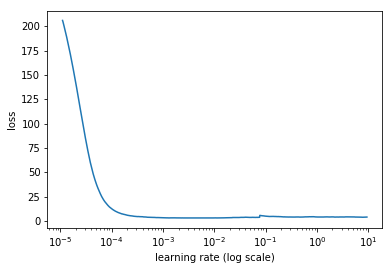

In [115]:
m.sched.plot()

In [116]:
loss_lrs = pd.DataFrame(list(zip(m.sched.losses, m.sched.lrs)), columns=['loss', 'lr'])

In [117]:
best = loss_lrs[loss_lrs['loss'] == m.sched.best]['lr'].values[0]
best

0.006506956844648881

In [118]:
m.fit(2e-5, 3, cycle_len = 1, cycle_mult = 2, metrics=[exp_rmse])

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      4.101118   4.702824   2.110798  
    1      2.993215   3.375254   1.785847                                                                              
    2      2.913964   3.310864   1.767934                                                                              
    3      2.842841   3.046188   1.695158                                                                              
    4      2.578391   2.974066   1.673801                                                                              
    5      2.678424   2.924331   1.660338                                                                              
    6      2.564853   2.92647    1.660759                                                                              


[2.92646978936475, 1.6607585108554386]

In [119]:
m.save('fastai4E')

In [62]:
m.load('fastai4E')

In [63]:
m.fit(1e-4, 1, cycle_len = 1, cycle_mult = 1, metrics=[exp_rmse])

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      2.447957   2.865611   1.640875  


[2.8656112139787098, 1.6408754544598003]

In [64]:
m.save('fastai5E')

In [34]:
m.fit(1e-4, 1, cycle_len = 3, cycle_mult = 1, metrics=[exp_rmse])

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      2.552183   2.993483   1.676786  
    1      2.322141   2.97691    1.67147                                                                               
    2      2.274471   2.968242   1.669349                                                                              



[2.9682424762207438, 1.6693489125501073]

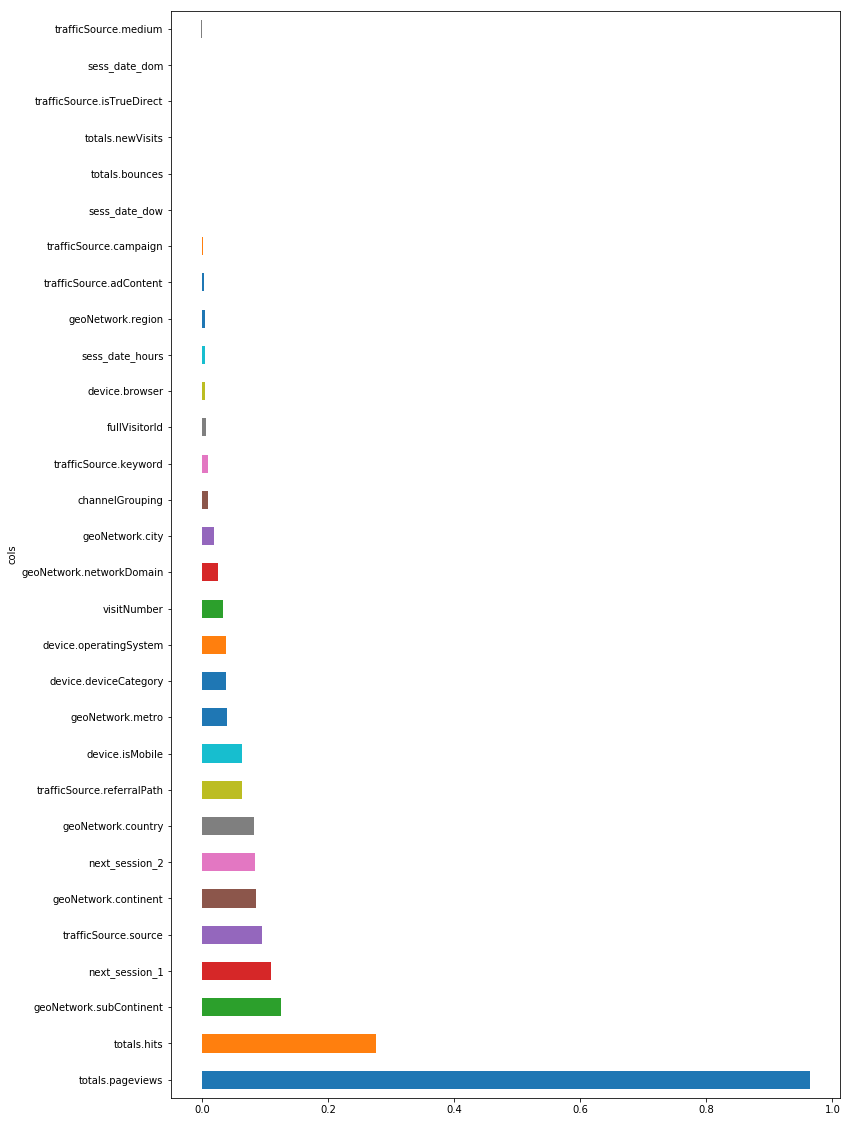

In [120]:
fi = nn_feat_importance(m, md, cat_cols, num_cols)
fi.plot('cols', 'imp', 'barh', figsize=(12,20), legend=False)

In [123]:
log_preds_train = m.predict_dl(m.data.trn_dl)
log_preds_val = m.predict_dl(m.data.val_dl)

log_preds_test = m.predict(True)

In [124]:
log_preds_test.mean(), log_preds_train.mean(), log_preds_val.mean()

(0.2145227, 0.28266373, 0.2796201)

# Results

In [125]:
test['PredictedLogRevenue'] = np.expm1(log_preds_test)

In [126]:
test_grouped = test.groupby(['fullVisitorId'], as_index=False).agg({'PredictedLogRevenue':'sum'})

In [127]:
test_grouped['PredictedLogRevenue'] = np.log1p(test_grouped['PredictedLogRevenue'])

In [128]:
csv_fn=f'{PATH}submission.csv'

test_grouped[['fullVisitorId','PredictedLogRevenue']].to_csv(csv_fn, index=False)